Branin synthetic function:

GP ERM versus GP dERM (winner)

https://www.sfu.ca/~ssurjano/branin.html

In [1]:
pip install pyGPGO


In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Branin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'ERM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Branin':

    # True y bounds:
    y_lb = 0.397887
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -5
    ub_x1 = +10
    lb_x2 = +0
    ub_x2 = +15

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) +
                 s * (1 - t) * np.cos(x1_training) + s)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 66
run_num_7 = 7
run_num_8 = 88
run_num_9 = 9
run_num_10 = 10
run_num_11 = 111
run_num_12 = 12
run_num_13 = 13
run_num_14 = 144
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]

    def ERM(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (gamma * norm.cdf(gamma)) + eps
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (norm.cdf(gamma) * dmdx + gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1	 [8.41909995 1.27566317]	 5.08993488	 5.08993488	 18.6 	 0.23031552 	 0.23031552 	 1.0 	 7.577
2  	 [ 8.98893195 10.45227242]	 70.52424257	 5.08993488	 17.7 	 0.23031552 	 0.23031552 	 1.0 	 6.409
3	 [-3.95603859 13.26220594]	 4.52504433	 4.52504433	 30.0 	 0.23031134 	 0.23031438 	 1.0 	 7.428
4  	 [ 5.36724215 15.        ]	 206.86194095	 4.52504433	 29.1 	 0.23031386 	 0.23031387 	 1.0 	 10.012
5	 [3.16378278 2.87919136]	 0.78643018	 0.78643018	 24.0 	 0.23029

In [15]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1  	 [ 7.11340143 15.        ]	 206.49201953	 6.69205151	 25.0 	 0.23031552 	 0.23031552 	 1.0 	 15.836
2	 [9.59366035 1.69164323]	 1.39845934	 1.39845934	 34.2 	 0.23031552 	 0.23031552 	 1.0 	 12.188
3  	 [-2.06875054 14.66010154]	 28.59516517	 1.39845934	 37.2 	 0.23031404 	 0.23031434 	 1.0 	 10.597
4  	 [9.22805834 7.49858923]	 27.46240479	 1.39845934	 35.4 	 0.23031541 	 0.23031544 	 1.0 	 10.408
5  	 [-5.          0.68880923]	 284.92592982	 1.39845934	 34.6 	 0.

In [16]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [6.70472147 4.59545299]	 30.72679181	 18.07886746	 9.8 	 0.23031552 	 0.23031552 	 1.0 	 2.632
2	 [-2.62849068 15.        ]	 17.03292032	 17.03292032	 27.2 	 0.23031552 	 0.23031552 	 1.0 	 13.487
3	 [2.6832042  0.77859294]	 4.92741738	 4.92741738	 29.6 	 0.22951812 	 0.2303133 	 0.997 	 11.005
4  	 [9.91437452 0.        ]	 10.04619424	 4.92741738	 28.5 	 0.23014763 	 0.23031401 	 0.999 	 13.13
5  	 [10.          8.34379921]	 30.46774043	 4.92741738	 2

In [17]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [ 1.25164457 13.57001383]	 100.61648848	 7.24712687	 23.7 	 0.23031552 	 0.23031552 	 1.0 	 8.841
2  	 [-4.27198795  1.64727177]	 188.41076038	 7.24712687	 22.0 	 0.23031519 	 0.23031519 	 1.0 	 7.555
3  	 [-4.26150559 11.356302  ]	 20.04482339	 7.24712687	 32.1 	 0.23025752 	 0.23031439 	 1.0 	 10.423
4  	 [3.90646661 8.49938403]	 48.57145211	 7.24712687	 32.1 	 0.23016879 	 0.23030769 	 0.999 	 9.848
5  	 [1.24693581 0.        ]	 30.83287425	 7.24712687	 35.1 	 

In [18]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1	 [8.84124421 0.03321319]	 5.96108856	 5.96108856	 24.9 	 0.23031552 	 0.23031552 	 1.0 	 8.345
2  	 [ 8.39476442 14.47736321]	 167.21523769	 5.96108856	 35.0 	 0.23031552 	 0.23031552 	 1.0 	 12.041
3  	 [-3.76636082  7.89302389]	 37.42253978	 5.96108856	 25.5 	 0.23028983 	 0.23031421 	 1.0 	 9.68
4  	 [-5.  0.]	 308.12909601	 5.96108856	 35.0 	 0.23025043 	 0.2303047 	 1.0 	 9.292
5  	 [3.90143584 0.        ]	 6.12610906	 5.96108856	 30.3 	 0.22983604 	 0.2

In [19]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68568633  2.00549341]	 86.03160634	 20.52092754	     	     	     	     	    
init	 [ 0.44028199 10.18663313]	 42.32854406	 20.52092754	     	     	     	     	    
init	 [-2.08324914  3.76815575]	 42.60068433	 20.52092754	     	     	     	     	    
init	 [6.37624587 8.36427884]	 72.27103718	 20.52092754	     	     	     	     	    
init	 [2.72204377 7.01699793]	 20.52092754	 20.52092754	     	     	     	     	    
1	 [7.21463272 0.59062929]	 16.15325247	 16.15325247	 18.3 	 0.23031552 	 0.23031552 	 1.0 	 5.965
2  	 [ 6.26585451 14.1821956 ]	 190.75793105	 16.15325247	 26.0 	 0.23031552 	 0.23031447 	 1.0 	 9.163
3	 [-4.16730594 14.83257316]	 5.02329063	 5.02329063	 28.0 	 0.23031552 	 0.23031552 	 1.0 	 8.661
4  	 [-5.         9.1644862]	 77.09025839	 5.02329063	 32.7 	 0.23025278 	 0.23031224 	 1.0 	 12.343
5  	 [2.2427495 0.       ]	 13.51103898	 5.02329063	 23.0 	 0.

In [20]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [-4.97859679  1.38393519]	 260.32939528	 5.21133532	 19.4 	 0.23031552 	 0.23031552 	 1.0 	 4.918
2  	 [ 7.42679792 14.12713902]	 178.37635729	 5.21133532	 29.4 	 0.23031551 	 0.23031551 	 1.0 	 9.399
3  	 [8.08940775 0.35854539]	 9.24962511	 5.21133532	 25.6 	 0.23031528 	 0.23031528 	 1.0 	 9.118
4  	 [-3.39684884  5.54228873]	 54.79871094	 5.21133532	 3.2 	 0.23031552 	 0.23031552 	 1.0 	 0.687
5  	 [4.5358044  5.91099674]	 28.31354782	 5.21133532	 29.4 	 0.230

In [21]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.71326574 7.60724532]	 48.93133297	 16.42817527	     	     	     	     	    
init	 [ 2.9251207  13.44427806]	 121.49896937	 16.42817527	     	     	     	     	    
init	 [ 5.49986786 10.71445653]	 108.19981146	 16.42817527	     	     	     	     	    
init	 [5.76007573 3.34229193]	 23.26238481	 16.42817527	     	     	     	     	    
init	 [-2.37268215  6.85262233]	 16.42817527	 16.42817527	     	     	     	     	    
1  	 [-3.65133406  0.20036416]	 179.39371011	 16.42817527	 24.9 	 0.23031552 	 0.23031552 	 1.0 	 6.675
2  	 [-5. 15.]	 17.50829952	 16.42817527	 30.3 	 0.23031538 	 0.23031552 	 1.0 	 16.28
3  	 [ 9.43700754 15.        ]	 157.01543975	 16.42817527	 27.0 	 0.23031538 	 0.23031395 	 1.0 	 7.793
4	 [10.  0.]	 10.96088904	 10.96088904	 33.9 	 0.23014283 	 0.23031194 	 0.999 	 8.401
5  	 [10.          6.54312196]	 14.47591144	 10.96088904	 30.8 	 0.23030241 	 0.2

In [22]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [ 7.05609655 14.75038872]	 200.43886887	 3.46402486	 11.6 	 0.23031552 	 0.23031552 	 1.0 	 3.99
2  	 [-0.46054038 14.56197292]	 79.46666176	 3.46402486	 25.4 	 0.23031552 	 0.23031552 	 1.0 	 8.377
3  	 [8.28747407 1.2035024 ]	 6.19638527	 3.46402486	 20.7 	 0.2303155 	 0.2303155 	 1.0 	 7.662
4  	 [5.1006069  9.09238292]	 75.24726471	 3.46402486	 32.2 	 0.23031549 	 0.23031443 	 1.0 	 10.824
5  	 [10.         6.1621617]	 11.92371748	 3.46402486	 24.6 	 0.23028

In [23]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [ 9.16391068 14.81438212]	 158.24127245	 2.71061096	 23.8 	 0.23031552 	 0.23031552 	 1.0 	 5.729
2  	 [9.65621089 6.61160737]	 16.13394234	 2.71061096	 23.0 	 0.23031552 	 0.23031552 	 1.0 	 6.814
3  	 [-3.43070383  6.59407857]	 41.58407101	 2.71061096	 31.0 	 0.23031552 	 0.23031552 	 1.0 	 9.019
4  	 [ 1.00699222 15.        ]	 124.78751331	 2.71061096	 37.4 	 0.2303142 	 0.23031455 	 1.0 	 10.209
5  	 [-5. 15.]	 17.50829952	 2.71061096	 26.2 	 0.22939193 	 0.

In [24]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.18255263 2.53604632]	 6.01740403	 6.01740403	     	     	     	     	    
init	 [ 1.54088529 11.53893709]	 69.34033362	 6.01740403	     	     	     	     	    
init	 [-0.57012043  2.23744436]	 40.28559663	 6.01740403	     	     	     	     	    
init	 [-4.66282513  6.30336738]	 108.05910203	 6.01740403	     	     	     	     	    
init	 [-1.41976788  5.06484288]	 23.38302591	 6.01740403	     	     	     	     	    
1  	 [ 9.15059304 14.25658747]	 144.83232904	 6.01740403	 25.5 	 0.23031552 	 0.23031552 	 1.0 	 11.103
2  	 [7.98004945 7.48781875]	 44.33620777	 6.01740403	 25.6 	 0.23031166 	 0.23031551 	 1.0 	 9.862
3  	 [10.  0.]	 10.96088904	 6.01740403	 21.4 	 0.23031479 	 0.23031552 	 1.0 	 10.712
4  	 [-4.6254104 13.0951224]	 18.3484395	 6.01740403	 27.2 	 0.23031548 	 0.23031548 	 1.0 	 7.275
5  	 [3.07548838 6.8346768 ]	 20.73695879	 6.01740403	 33.0 	 0.22656921 	 0.2

In [25]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [10.          3.97966615]	 2.89710219	 0.54993153	 21.9 	 0.23145744 	 0.23146071 	 1.0 	 8.718
2  	 [ 9.19833734 12.85785838]	 112.30961384	 0.54993153	 23.2 	 0.23031552 	 0.23031552 	 1.0 	 10.023
3  	 [-4.8799499   0.15657603]	 290.04049818	 0.54993153	 27.0 	 0.23031552 	 0.23031552 	 1.0 	 9.14
4  	 [ 2.04669017 14.76522594]	 137.42552683	 0.54993153	 27.8 	 0.23031547 	 0.23031551 	 1.0 	 9.486
5  	 [1.56822938 3.10391452]	 10.53999972	 0.54993153	 31.5 	 0.2

In [26]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1  	 [-3.51870171  3.68338658]	 91.63196166	 18.03894306	 12.2 	 0.23031552 	 0.23031552 	 1.0 	 4.628
2	 [-3.06562888 11.40851515]	 0.8943531	 0.8943531	 23.8 	 0.23031552 	 0.23031552 	 1.0 	 8.506
3  	 [2.37048566 0.        ]	 11.83515047	 0.8943531	 29.4 	 0.23029084 	 0.23031411 	 1.0 	 10.405
4  	 [1.70834797 5.95432431]	 13.95602696	 0.8943531	 33.6 	 0.23030321 	 0.23030819 	 1.0 	 11.438
5  	 [-0.26045708 15.        ]	 92.83814344	 0.8943531	 31.2 	 0

In [27]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.59983913 13.3641452 ]	 1.39008244	 1.39008244	     	     	     	     	    
init	 [2.15101746 2.6028287 ]	 5.06258176	 1.39008244	     	     	     	     	    
init	 [5.66659793 7.61961773]	 59.95574639	 1.39008244	     	     	     	     	    
init	 [ 1.88565728 12.11064259]	 81.89070663	 1.39008244	     	     	     	     	    
init	 [5.19935765 4.42757614]	 24.79948444	 1.39008244	     	     	     	     	    
1  	 [-5.          4.05886877]	 185.08103521	 1.39008244	 21.6 	 0.23031552 	 0.23031552 	 1.0 	 14.685
2  	 [ 9.18932323 13.33919603]	 122.89011692	 1.39008244	 26.0 	 0.23031552 	 0.23031552 	 1.0 	 8.608
3  	 [10.        1.093864]	 5.58777522	 1.39008244	 20.7 	 0.23026317 	 0.23031521 	 1.0 	 8.062
4  	 [-0.21800425  7.07301198]	 19.89310787	 1.39008244	 20.4 	 0.23025114 	 0.23029425 	 1.0 	 5.981
5  	 [-1.61353616  0.        ]	 88.87725753	 1.39008244	 29.1 	 0.22

In [28]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [ 6.5655417  11.87699252]	 134.9501135	 12.76872453	 31.6 	 0.23031552 	 0.23031552 	 1.0 	 10.227
2  	 [-4.77493765 13.49591113]	 19.8969065	 12.76872453	 27.8 	 0.23031552 	 0.23031552 	 1.0 	 7.902
3  	 [ 0.59698328 15.        ]	 116.03225352	 12.76872453	 33.4 	 0.23031534 	 0.23031437 	 1.0 	 10.922
4	 [2.88550833 0.        ]	 6.87721034	 6.87721034	 28.2 	 0.23029147 	 0.23031365 	 1.0 	 7.549
5  	 [10.          7.39895525]	 21.26794479	 6.87721034

In [29]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [ 5.63879248 14.58068289]	 198.51319639	 2.71586401	 28.8 	 0.23031552 	 0.23031552 	 1.0 	 9.433
2  	 [9.4202829  9.76772141]	 53.63704948	 2.71586401	 32.0 	 0.2303154 	 0.23031504 	 1.0 	 9.003
3  	 [3.95687423 7.84188729]	 40.83173356	 2.71586401	 35.2 	 0.23031551 	 0.23031243 	 1.0 	 12.773
4  	 [-5.          2.46781698]	 229.38869958	 2.71586401	 36.2 	 0.23031551 	 0.23031327 	 1.0 	 12.732
5  	 [10.          4.36702292]	 3.80381757	 2.71586401	 23.2 	 0.2301

In [30]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1	 [9.76575296 0.98553483]	 4.16232783	 4.16232783	 23.1 	 0.23031552 	 0.23031552 	 1.0 	 9.038
2  	 [-0.36591853 14.49945231]	 81.37289477	 4.16232783	 30.2 	 0.23031552 	 0.23031552 	 1.0 	 13.529
3	 [3.74599703 2.35814314]	 2.3563458	 2.3563458	 31.5 	 0.23031521 	 0.23031511 	 1.0 	 8.922
4  	 [10.         14.68093252]	 138.31826216	 2.3563458	 26.1 	 0.23031521 	 0.23031398 	 1.0 	 8.81
5  	 [-5.         11.18236621]	 48.78370533	 2.3563458	 35.8 	 0.230

In [31]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [-4.83474958 11.77354131]	 35.58412906	 8.15007522	 16.6 	 0.23031552 	 0.23031552 	 1.0 	 5.711
2  	 [-1.52308094  7.08739393]	 13.13561552	 8.15007522	 27.0 	 0.23030714 	 0.23031465 	 1.0 	 8.152
3  	 [9.31856589 6.6736343 ]	 18.82838651	 8.15007522	 33.2 	 0.23031544 	 0.23031463 	 1.0 	 7.96
4  	 [-0.65565236 15.        ]	 80.03633492	 8.15007522	 34.0 	 0.23027213 	 0.23029765 	 1.0 	 10.471
5  	 [-0.12756076 10.65515995]	 39.32694073	 8.15007522	 25.2 	

In [32]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1	 [9.57054653 2.03489665]	 0.81985976	 0.81985976	 22.5 	 0.23031552 	 0.23031552 	 1.0 	 8.307
2  	 [4.12061113 5.90343481]	 22.86035368	 0.81985976	 27.6 	 0.23031442 	 0.23031535 	 1.0 	 9.17
3  	 [-5.          6.34654193]	 130.24709009	 0.81985976	 30.8 	 0.23030712 	 0.23031253 	 1.0 	 10.348
4  	 [ 0.07528122 15.        ]	 102.73256693	 0.81985976	 37.5 	 0.23030712 	 0.23030965 	 1.0 	 10.598
5  	 [5.33378116 0.        ]	 16.99716291	 0.81985976	 30.0 	 0.

In [33]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [9.72940248 6.45210567]	 14.59042722	 14.0426674	 32.6 	 0.23025895 	 0.23031464 	 1.0 	 11.953
2  	 [-4.4669446   1.82165655]	 199.91617578	 14.0426674	 28.2 	 0.23031552 	 0.23031552 	 1.0 	 9.356
3	 [10.          0.94279974]	 6.18738699	 6.18738699	 31.0 	 0.229911 	 0.23031305 	 0.998 	 12.568
4  	 [-0.52618573 12.88666658]	 54.46478818	 6.18738699	 26.7 	 0.23031552 	 0.23031481 	 1.0 	 7.319
5  	 [0.7855373 0.       ]	 40.11278933	 6.18738699	 32.4 	 0.2

In [34]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1	 [8.41909995 1.27566317]	 5.08993488	 5.08993488	 22.8 	 0.23031552 	 0.23031552 	 1.0 	 15.517
2  	 [10. 15.]	 145.87219088	 5.08993488	 23.6 	 0.23031552 	 0.23031552 	 1.0 	 16.047
3  	 [10.          7.80724463]	 25.02432412	 5.08993488	 21.8 	 0.23031552 	 0.23031549 	 1.0 	 5.745
4  	 [-4.67712792 14.21955317]	 13.86524479	 5.08993488	 25.6 	 0.23031552 	 0.23031552 	 1.0 	 7.761
5  	 [4.42114297 4.28364423]	 15.05485122	 5.08993488	 26.8 	 0.23029352 	 0.2

In [35]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1  	 [ 6.61704288 15.        ]	 211.5868373	 6.69205151	 27.9 	 0.23031552 	 0.23031552 	 1.0 	 11.357
2	 [9.59366035 1.69164323]	 1.39845934	 1.39845934	 35.2 	 0.23031552 	 0.23031552 	 1.0 	 12.818
3  	 [9.30489944 6.72022075]	 19.3413442	 1.39845934	 33.0 	 0.23031404 	 0.23031547 	 1.0 	 13.095
4  	 [ 1.09618628 13.66538586]	 100.03920945	 1.39845934	 31.4 	 0.2303071 	 0.23031461 	 1.0 	 9.318
5  	 [10.         11.28615892]	 70.55458124	 1.39845934	 22.2 	 0.2299

In [36]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [6.70472147 4.59545299]	 30.72679181	 18.07886746	 20.4 	 0.23031552 	 0.23031552 	 1.0 	 1.498
2	 [-3.89564496 13.38589781]	 3.60101937	 3.60101937	 22.0 	 0.23031552 	 0.23031552 	 1.0 	 4.136
3  	 [ 1.07989608 15.        ]	 126.21043949	 3.60101937	 27.1 	 0.23016414 	 0.2303133 	 0.999 	 9.664
4  	 [2.18373178 0.93419221]	 9.34407874	 3.60101937	 23.4 	 0.23031303 	 0.23031447 	 1.0 	 4.364
5  	 [10.          8.70633978]	 34.47172028	 3.60101937	 2

In [37]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [ 1.25164457 13.57001383]	 100.61648848	 7.24712687	 31.0 	 0.23031552 	 0.23031552 	 1.0 	 8.486
2  	 [-4.27198795  1.64727177]	 188.41076038	 7.24712687	 13.6 	 0.23031519 	 0.23031519 	 1.0 	 16.873
3  	 [4.54167729 8.36860941]	 56.4247929	 7.24712687	 28.3 	 0.23025752 	 0.23031439 	 1.0 	 7.288
4  	 [10. 15.]	 145.87219088	 7.24712687	 25.6 	 0.22821477 	 0.23031539 	 0.991 	 12.969
5  	 [-4.73699493 13.33053872]	 19.89224027	 7.24712687	 28.8 	 0.230315 	 0.

In [38]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1	 [8.84124421 0.03321319]	 5.96108856	 5.96108856	 24.4 	 0.23031552 	 0.23031552 	 1.0 	 19.773
2  	 [ 8.39476442 14.47736321]	 167.21523769	 5.96108856	 31.0 	 0.23031552 	 0.23031552 	 1.0 	 6.838
3  	 [-4.12595137  8.72186434]	 41.21567415	 5.96108856	 26.6 	 0.23028983 	 0.23031421 	 1.0 	 7.453
4  	 [4.37131701 2.395214  ]	 7.56934382	 5.96108856	 29.3 	 0.23025043 	 0.2303047 	 1.0 	 8.537
5  	 [-4.93023805  0.58417308]	 281.12270116	 5.96108856	 26.1 	

In [39]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68568633  2.00549341]	 86.03160634	 20.52092754	     	     	     	     	    
init	 [ 0.44028199 10.18663313]	 42.32854406	 20.52092754	     	     	     	     	    
init	 [-2.08324914  3.76815575]	 42.60068433	 20.52092754	     	     	     	     	    
init	 [6.37624587 8.36427884]	 72.27103718	 20.52092754	     	     	     	     	    
init	 [2.72204377 7.01699793]	 20.52092754	 20.52092754	     	     	     	     	    
1	 [7.21463272 0.59062929]	 16.15325247	 16.15325247	 19.4 	 0.23031552 	 0.23031552 	 1.0 	 6.74
2  	 [ 9.99839357 15.        ]	 145.90204607	 16.15325247	 19.7 	 0.23031552 	 0.23031447 	 1.0 	 5.075
3	 [-4.16730594 14.83257316]	 5.02329063	 5.02329063	 28.0 	 0.23031552 	 0.23031552 	 1.0 	 9.362
4  	 [ 4.05822241 15.        ]	 181.88069352	 5.02329063	 31.6 	 0.23031429 	 0.23031454 	 1.0 	 8.589
5  	 [2.07718894 0.        ]	 15.91462475	 5.02329063	 27.6 	

In [40]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [-4.97859679  1.38393519]	 260.32939528	 5.21133532	 28.0 	 0.23031552 	 0.23031552 	 1.0 	 13.038
2  	 [ 7.42679792 14.12713902]	 178.37635729	 5.21133532	 32.2 	 0.23031551 	 0.23031551 	 1.0 	 10.052
3  	 [8.08940775 0.35854539]	 9.24962511	 5.21133532	 17.5 	 0.23031528 	 0.23031528 	 1.0 	 6.148
4  	 [-3.39684884  5.54228873]	 54.79871094	 5.21133532	 22.0 	 0.23031552 	 0.23031552 	 1.0 	 0.529
5  	 [5.03816352 5.18518457]	 28.47532467	 5.21133532	 31.3 	 0.

In [41]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.71326574 7.60724532]	 48.93133297	 16.42817527	     	     	     	     	    
init	 [ 2.9251207  13.44427806]	 121.49896937	 16.42817527	     	     	     	     	    
init	 [ 5.49986786 10.71445653]	 108.19981146	 16.42817527	     	     	     	     	    
init	 [5.76007573 3.34229193]	 23.26238481	 16.42817527	     	     	     	     	    
init	 [-2.37268215  6.85262233]	 16.42817527	 16.42817527	     	     	     	     	    
1  	 [-5.  0.]	 308.12909601	 16.42817527	 24.0 	 0.23031552 	 0.23031552 	 1.0 	 10.325
2  	 [10. 15.]	 145.87219088	 16.42817527	 31.6 	 0.23031538 	 0.23031389 	 1.0 	 13.578
3  	 [-4.96388188 14.55986363]	 18.75765051	 16.42817527	 24.6 	 0.23031552 	 0.23031552 	 1.0 	 5.707
4  	 [1.09237049 1.08513567]	 25.51257428	 16.42817527	 29.6 	 0.23030393 	 0.23031334 	 1.0 	 6.246
5  	 [10.         7.4201581]	 21.45480973	 16.42817527	 25.5 	 0.23029567 	 0.230

In [42]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [ 7.05609655 14.75038872]	 200.43886887	 3.46402486	 27.0 	 0.23031552 	 0.23031552 	 1.0 	 15.143
2  	 [10.          6.08816298]	 11.46163906	 3.46402486	 27.6 	 0.23031552 	 0.23031552 	 1.0 	 14.004
3  	 [ 0.70206139 11.72052977]	 63.22140928	 3.46402486	 24.4 	 0.23031552 	 0.23031552 	 1.0 	 5.564
4  	 [6.81885185 2.24986189]	 19.45778425	 3.46402486	 25.5 	 0.23024171 	 0.23031448 	 1.0 	 9.179
5  	 [5.09933164 8.25800692]	 62.82857245	 3.46402486	 26.2 	 

In [43]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [10.          7.25960215]	 20.06217196	 2.71061096	 27.2 	 0.23031552 	 0.23031552 	 1.0 	 5.811
2  	 [10. 15.]	 145.87219088	 2.71061096	 28.0 	 0.23031552 	 0.23031552 	 1.0 	 20.485
3  	 [-3.43070383  6.59407857]	 41.58407101	 2.71061096	 27.4 	 0.23031552 	 0.23031552 	 1.0 	 8.49
4  	 [ 0.84877373 15.        ]	 121.56850705	 2.71061096	 27.0 	 0.23031421 	 0.23031453 	 1.0 	 5.569
5  	 [-4.09924692 14.83375461]	 4.49382743	 2.71061096	 29.9 	 0.2292041 	 0.

In [44]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.18255263 2.53604632]	 6.01740403	 6.01740403	     	     	     	     	    
init	 [ 1.54088529 11.53893709]	 69.34033362	 6.01740403	     	     	     	     	    
init	 [-0.57012043  2.23744436]	 40.28559663	 6.01740403	     	     	     	     	    
init	 [-4.66282513  6.30336738]	 108.05910203	 6.01740403	     	     	     	     	    
init	 [-1.41976788  5.06484288]	 23.38302591	 6.01740403	     	     	     	     	    
1  	 [10.         13.79986103]	 118.51628573	 6.01740403	 28.0 	 0.23031552 	 0.23031552 	 1.0 	 12.595
2  	 [8.08760854 7.43897523]	 42.12743744	 6.01740403	 23.2 	 0.23031551 	 0.2303155 	 1.0 	 6.496
3	 [-3.34382987 14.79978673]	 4.72861694	 4.72861694	 25.8 	 0.23031479 	 0.23031552 	 1.0 	 7.417
4	 [10.         2.9121648]	 1.95138382	 1.95138382	 31.2 	 0.23023657 	 0.23031416 	 1.0 	 6.041
5  	 [ 5.45530756 14.07795313]	 183.31223157	 1.95138382	 28.9 	 0.22

In [45]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [10.          4.00834396]	 2.9539444	 0.54993153	 30.6 	 0.23145744 	 0.23146071 	 1.0 	 17.741
2  	 [10. 15.]	 145.87219088	 0.54993153	 23.8 	 0.23031552 	 0.23031552 	 1.0 	 11.584
3  	 [-4.8799499   0.15657603]	 290.04049818	 0.54993153	 25.8 	 0.23031552 	 0.23031552 	 1.0 	 7.355
4  	 [ 2.96504557 14.18967184]	 139.14981054	 0.54993153	 28.3 	 0.23031552 	 0.23031552 	 1.0 	 8.671
5  	 [10.          9.14096931]	 39.61834064	 0.54993153	 32.6 	 0.23031199 	 0.2

In [46]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1  	 [-3.51870171  3.68338658]	 91.63196166	 18.03894306	 19.0 	 0.23031552 	 0.23031552 	 1.0 	 2.371
2	 [-3.06562888 11.40851515]	 0.8943531	 0.8943531	 27.4 	 0.23031552 	 0.23031552 	 1.0 	 7.015
3  	 [0.75393026 7.08230087]	 21.87872614	 0.8943531	 24.4 	 0.23029084 	 0.23031411 	 1.0 	 7.992
4  	 [ 0.25948851 15.        ]	 107.72132186	 0.8943531	 35.3 	 0.23026273 	 0.23031289 	 1.0 	 8.78
5  	 [-4.28085851  8.17831417]	 55.01582572	 0.8943531	 22.8 	 0

In [47]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.59983913 13.3641452 ]	 1.39008244	 1.39008244	     	     	     	     	    
init	 [2.15101746 2.6028287 ]	 5.06258176	 1.39008244	     	     	     	     	    
init	 [5.66659793 7.61961773]	 59.95574639	 1.39008244	     	     	     	     	    
init	 [ 1.88565728 12.11064259]	 81.89070663	 1.39008244	     	     	     	     	    
init	 [5.19935765 4.42757614]	 24.79948444	 1.39008244	     	     	     	     	    
1  	 [ 8.87825297 13.83583851]	 140.64173785	 1.39008244	 24.1 	 0.23031552 	 0.23031552 	 1.0 	 5.889
2  	 [-4.31479606  4.9998395 ]	 111.80549081	 1.39008244	 22.2 	 0.23031552 	 0.23031552 	 1.0 	 5.019
3  	 [9.92871642 3.1892425 ]	 1.65726615	 1.39008244	 25.2 	 0.23026317 	 0.23031521 	 1.0 	 5.834
4  	 [-5.  0.]	 308.12909601	 1.39008244	 19.4 	 0.23020726 	 0.23029707 	 1.0 	 6.079
5  	 [-0.23872117  7.87413476]	 21.54049001	 1.39008244	 25.9 	 0.22981286 	 0.230

In [48]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [ 6.5655417  11.87699252]	 134.9501135	 12.76872453	 32.6 	 0.23031552 	 0.23031552 	 1.0 	 20.593
2  	 [-4.77493765 13.49591113]	 19.8969065	 12.76872453	 25.6 	 0.23031552 	 0.23031552 	 1.0 	 7.153
3  	 [ 1.02371323 15.        ]	 125.11707181	 12.76872453	 20.0 	 0.23031534 	 0.23031437 	 1.0 	 15.996
4  	 [4.35176896 6.82771086]	 34.77911379	 12.76872453	 24.2 	 0.23029147 	 0.23031365 	 1.0 	 7.113
5  	 [10.          7.41803091]	 21.43602181	 12.768

In [49]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [ 5.63879248 14.58068289]	 198.51319639	 2.71586401	 34.8 	 0.23031552 	 0.23031552 	 1.0 	 10.313
2  	 [9.70186832 9.71113747]	 49.65903284	 2.71586401	 29.8 	 0.2303154 	 0.23031504 	 1.0 	 11.348
3  	 [-5.  0.]	 308.12909601	 2.71586401	 36.0 	 0.23031551 	 0.23031374 	 1.0 	 18.62
4  	 [ 1.83795616 10.92486013]	 62.42749636	 2.71586401	 32.4 	 0.23018697 	 0.2303136 	 0.999 	 6.006
5  	 [4.7901126  7.11014336]	 44.03479809	 2.71586401	 22.9 	 0.23003404 	 0.23015

In [50]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1	 [9.76575296 0.98553483]	 4.16232783	 4.16232783	 26.5 	 0.23031552 	 0.23031552 	 1.0 	 9.0
2  	 [-0.36591853 14.49945231]	 81.37289477	 4.16232783	 31.5 	 0.23031552 	 0.23031552 	 1.0 	 9.26
3  	 [10. 15.]	 145.87219088	 4.16232783	 22.6 	 0.23031521 	 0.23031511 	 1.0 	 8.645
4  	 [3.25972871 0.        ]	 5.23761158	 4.16232783	 28.3 	 0.23030722 	 0.2303145 	 1.0 	 7.542
5  	 [9.29977095 5.44257151]	 9.9038485	 4.16232783	 23.4 	 0.23017059 	 0.23030978

In [51]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [-4.83474958 11.77354131]	 35.58412906	 8.15007522	 24.6 	 0.23031552 	 0.23031552 	 1.0 	 5.263
2  	 [-2.05332579  5.79675967]	 21.67163239	 8.15007522	 25.0 	 0.23030714 	 0.23031465 	 1.0 	 5.512
3  	 [-0.40023844 14.12150528]	 74.55172686	 8.15007522	 26.8 	 0.23025111 	 0.23030263 	 1.0 	 16.244
4	 [3.18387434 3.39063949]	 1.72525103	 1.72525103	 22.4 	 0.22956223 	 0.23027882 	 0.997 	 4.911
5  	 [-0.76931326  9.98576053]	 24.10675472	 1.72525103	 29.0 	

In [52]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1	 [9.57054653 2.03489665]	 0.81985976	 0.81985976	 16.6 	 0.23031552 	 0.23031552 	 1.0 	 15.23
2  	 [1.15615242 7.63863574]	 24.79818042	 0.81985976	 25.0 	 0.23031442 	 0.23031535 	 1.0 	 9.836
3  	 [10. 15.]	 145.87219088	 0.81985976	 20.8 	 0.23030712 	 0.23031251 	 1.0 	 20.066
4  	 [4.96127526 3.48190556]	 17.19749798	 0.81985976	 31.2 	 0.23030843 	 0.23031222 	 1.0 	 12.372
5  	 [ 0.46088083 13.6387904 ]	 88.23700721	 0.81985976	 27.4 	 0.22996641 	 0.230

In [53]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [7.59246884 6.91559094]	 43.31240837	 14.0426674	 24.8 	 0.23025895 	 0.23031464 	 1.0 	 7.286
2  	 [-4.4669446   1.82165655]	 199.91617578	 14.0426674	 20.4 	 0.23031552 	 0.23031552 	 1.0 	 2.569
3  	 [-0.92129209 14.36070813]	 61.84047809	 14.0426674	 21.6 	 0.229911 	 0.23031217 	 0.998 	 9.051
4	 [9.27672345 3.31678741]	 1.43192799	 1.43192799	 23.0 	 0.23031001 	 0.2303131 	 1.0 	 4.167
5  	 [0.58899051 3.1032798 ]	 22.00070416	 1.43192799	 17.8 	 0.2296

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.9453509695467525, 1.073908055490022)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.0005721783316311656, -0.21004754162216754)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(0.5725369933981715, 1.164129196584808)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(0.9092882389142689, 1.663444596146684)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(1.2012853759186732, 1.2486960607478013)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(1.1316097574747643, 0.4845729153696028)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.7869126845001327, 0.7873311761630061)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.46646121583930045, 1.1524690500912285)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(0.2227126650035151, 0.6140350726042493)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.6062723502880838, 0.5809737356446687)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(1.2346799348264186, 0.44050839994269153)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-1.8835818529313322, -1.8835818529313322)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-3.1452539058320927, -0.7002400699524578)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-0.007835170045524763, -0.007835170045524763)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.2093340051742938, 0.7443189666853792)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8406948255363631, 0.5925077719990494)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.44154027057271805, 1.3255993329913722)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(1.8020663123543492, 0.28319504581582894)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-1.1097209691850667, -0.8628145206943092)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.7262935177873249, 0.03347441365905568)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-27.68166689936483,
 0.23031552222712293,
 0.23031552222712293,
 22.8,
 15.516556875519726,
 -5.089934878453152,
 0.23031552222712293,
 0.23031552222533191,
 23.6,
 16.046637672210032,
 -5.089934878453152,
 0.2303155216869589,
 0.2303154895568758,
 21.8,
 5.744991776184966,
 -5.089934878453152,
 0.2303155209914797,
 0.2303155209914797,
 25.6,
 7.761473953320194,
 -5.089934878453152,
 0.2302935162984516,
 0.23031348491241585,
 26.8,
 5.30866141351675,
 -5.089934878453152,
 0.23025676243482993,
 0.2302329745144009,
 21.4,
 5.886768761145509,
 -5.089934878453152,
 0.2298035917248371,
 0.23023295026328539,
 18.8,
 8.881457503461814,
 -5.089934878453152,
 0.23006210931074803,
 0.23023297940816648,
 24.0,
 4.426706964671929,
 -5.089934878453152,
 0.22822983644390057,
 0.2297004112220597,
 26.1,
 5.310747067277873,
 -5.089934878453152,
 0.22660827172146106,
 0.22970042756166267,
 22.6,
 3.638701707450289,
 -5.089934878453152,
 0.18881842560629977,
 0.21046547249111253,
 24.8,
 2.518331248933

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([5.08993488, 5.08993488, 5.08993488, 5.08993488, 5.08993488,
       5.08993488, 5.08993488, 5.08993488, 5.08993488, 5.08993488,
       5.08993488, 3.32468226, 3.32468226, 3.32468226, 3.32468226,
       3.32468226, 3.32468226, 3.32468226, 3.32468226, 3.32468226])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.22948760545728078,
 0.2303136605684842,
 1.2084327103962593,
 1.3984593420568778)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.230315517386824, 0.2303155221780734, 3.6010193697779265, 2.170645828664802)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(0.006223993620564399,
 0.10742073211122549,
 5.675345283671863,
 2.8804419184155465)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.2300964667786657,
 0.23010151795822115,
 3.8836817282277147,
 3.7222742649858063)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.12632930956790253,
 0.16104823279482652,
 2.021368496765593,
 3.498530769385108)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.018956687884386817, 2e-08, 2.5954107893535863, 2.594491336373898)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.23005848288700195, 0.2303119449390752, 3.563887280610216, 1.992229165660346)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(0.18641420696355102,
 0.22709339565388925,
 2.2457596760494303,
 1.6473485081343497)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.21635197716874152,
 0.22146514114409227,
 2.1856654070338255,
 2.2314706860746085)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.23023656914124727,
 0.23031415766190727,
 1.951383815470761,
 3.8351651915849647)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.23145743927034393,
 0.2314607113584278,
 0.5499315281120278,
 0.5499315281120278)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.23031552207762704,
 0.23031552207762704,
 0.8943531028899869,
 0.44094299049175056)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.23031552162051053,
 0.23031552222261342,
 1.3900824448893765,
 1.3900824448893765)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.17921947138189137,
 0.19674709729647674,
 2.5028943665678174,
 3.749138992674827)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.230211696889224, 0.23031043138604293, 2.2064050843471854, 2.715864006988424)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.23031552222712293,
 0.23031552222712293,
 4.1623278326263815,
 1.9529876505413295)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.22956223008730015,
 0.2302788222341027,
 1.7252510333712205,
 6.460047849536947)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.2303155222178744,
 0.2303155222178744,
 0.8198597583535783,
 0.7275379310112928)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.23031000667792692,
 0.2303130955145124,
 1.4319279860625826,
 6.017672622904149)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(24.0, 30.7)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(34.2, 24.6)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(23.6, 22.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(35.6, 20.2)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(24.3, 23.2)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(19.6, 15.7)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(21.6, 23.4)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(19.5, 28.0)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(27.0, 16.8)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(25.8, 15.6)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(16.0, 31.2)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(21.9, 30.6)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(17.7, 27.4)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(21.6, 24.1)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(27.2, 15.6)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(28.8, 26.2)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(24.0, 26.5)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(26.8, 22.4)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(24.6, 16.6)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(21.3, 23.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(7.555831774570836, 7.378947080103539)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(8.845825998966074, 9.348853494240482)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(6.61117589936466, 6.935247295824763)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(7.702860569743004, 8.952543466209125)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(9.667966726130313, 8.545365653040658)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(6.481561116235876, 7.758405257720822)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(5.767643777054927, 6.1403285051515955)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(7.255978431592088, 6.041952609438605)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(7.58210455766184, 7.298304611877957)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(8.107050486730127, 6.811309823686824)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(6.660351167190788, 6.221387621939748)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(7.457211595206902, 9.451283254568803)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(7.142915474719089, 6.012470440220881)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(7.600181150081025, 6.648813161354163)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(7.115096663958662, 6.718389503309401)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(7.481756564857632, 9.69961619826738)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(7.783289515623477, 6.686946225107933)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(7.517000521400402, 5.685227291887104)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(7.637837784157402, 8.979256607674067)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(7.32518963450895, 5.9243109310791064)

In [157]:
### Summarise arrays: 'GP ERM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dERM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP ERM maximum (when compared to GP dERM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dERM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP ERM, resultant tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dERM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP ERM, average nfev at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(24.255000000000003, 23.189999999999998)

In [162]:
### Summarise arrays: 'GP ERM, average Euclid at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(7.4649414704877035, 7.361947951635149)

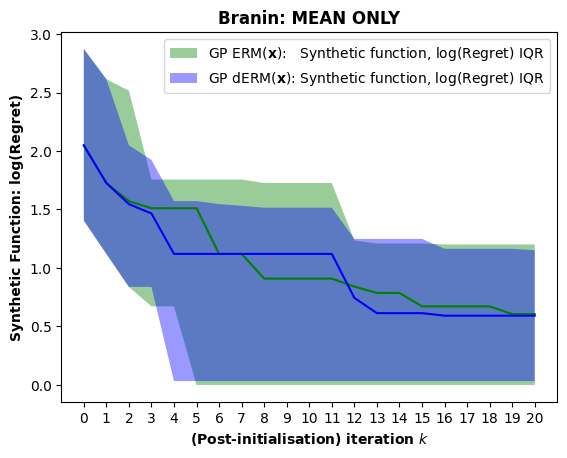

In [163]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP dERM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


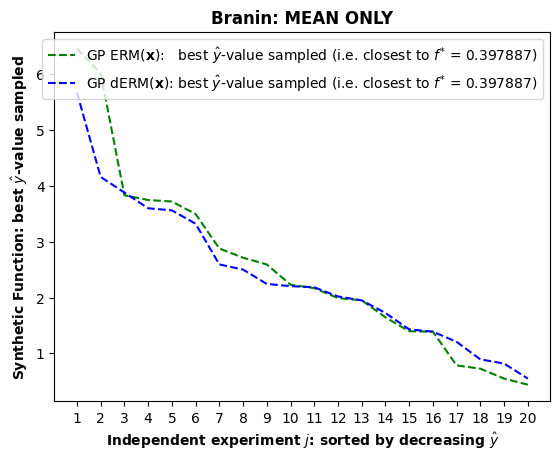

In [164]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Green', ls='--', label='GP ERM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Blue', ls='--', label='GP dERM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


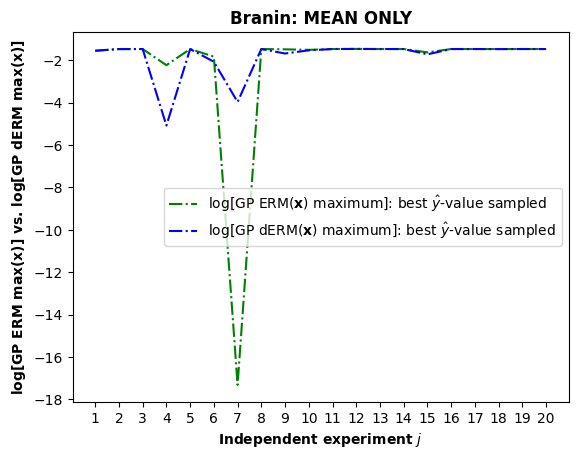

In [165]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Green', ls='-.', label='log[GP ERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Blue', ls='-.', label='log[GP dERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP ERM max($\mathbf{x}$)] vs. log[GP dERM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


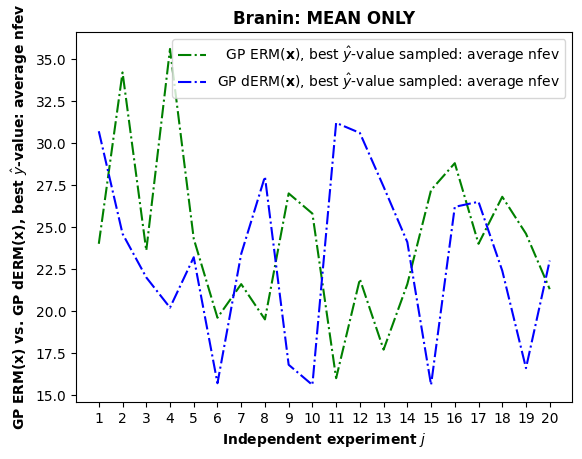

In [166]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


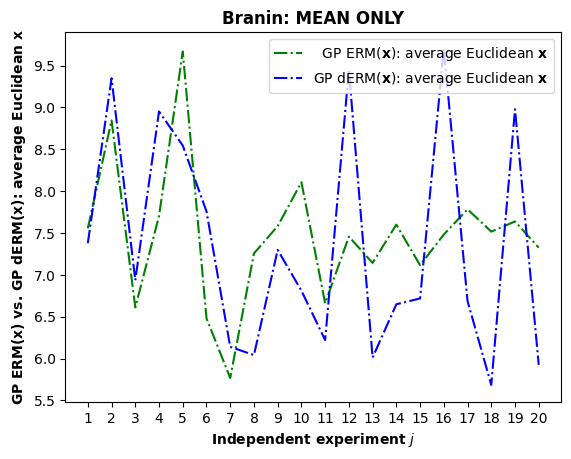

In [167]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([-0.0997,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        -0.    , -0.    , -0.    , -0.    , -0.    , -0.    ,  0.    ,
        -0.    ,  0.    , -0.    , -0.    , -0.    , -0.    ]),
 0.0,
 array([-4.78056385,  2.77998439]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([-0.185 ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        -0.0125, -0.    , -0.    , -0.189 , -0.2416, -0.1975,  0.    ,
        -0.0309,  0.    , -0.    , -0.    , -0.1426, -0.    ]),
 0.0,
 array([-4.78056385,  2.77998439]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 1.4601,  6.6803],
       [-4.7806,  2.78  ],
       [ 3.5666,  9.8085],
       [ 4.6679, 14.2133],
       [ 0.4346, 12.9307],
       [ 6.2632, 10.4714],
       [ 7.6566, 13.3655],
       [ 5.9354,  0.2983],
       [-1.3976,  6.5174],
       [ 2.8058, 14.237 ],
       [ 4.2646, 11.9636],
       [ 5.8895,  3.2226],
       [-1.3607,  6.5216],
       [-2.7897,  6.9884],
       [ 4.211 , 11.825 ],
       [ 4.8758, 12.7596],
       [ 6.4103,  0.1133],
       [ 7.9275,  6.8639],
       [ 5.2153,  3.5421],
       [-1.3753,  6.5202]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[ 0.9663,  7.5591],
       [-4.7806,  2.78  ],
       [-3.5479,  3.2715],
       [ 4.6679, 14.2133],
       [ 0.4346, 12.9307],
       [ 6.2632, 10.4714],
       [ 7.6566, 13.3655],
       [ 5.4561,  0.9362],
       [-2.8716,  7.7314],
       [ 2.9061, 14.1215],
       [ 3.4857, 12.1579],
       [ 3.8254,  0.7212],
       [ 0.9943,  7.7272],
       [-2.7897,  6.9884],
       [ 3.8146, 11.9597],
       [ 4.8758, 12.7596],
       [ 6.6284,  0.    ],
       [ 7.7242,  5.2361],
       [ 4.4069,  4.2628],
       [-4.2531,  3.7519]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


4.787045597354683

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

11.406619535263731